In [62]:
import pandas as pd
import numpy as np
import wrangle as w

# modeling methods
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import matplotlib.pyplot as plt

In [2]:
train, validate, test = w.wrangle_zillow()

opening data from local file


In [3]:
train_scaled, validate_scaled, test_scaled = w.impute_and_scale(train, validate, test)

In [4]:
drops = ['tax_value','lot_size_binned']

In [5]:
X_train_scaled = train_scaled.drop(columns=drops)
y_train = train_scaled.tax_value
X_validate_scaled = validate_scaled.drop(columns=drops)
y_validate = validate_scaled.tax_value
X_test_scaled = test_scaled.drop(columns=drops)
y_test = test_scaled.tax_value

# Feature selection

In [6]:
# parameters: f_regression stats test, give me 4 features
f_selector = SelectKBest(f_regression, k=4)

# find the top 3 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature_kbest = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [7]:
f_feature_kbest

['bathrooms', 'area', 'garage_sqft', 'year_built']

In [8]:
f_feature_kbest = ['region', 'area', 'garage_sqft', 'year_built']

In [9]:
lm = LinearRegression()
# parameters: f_regression stats test, give me 4 features
f_selector = RFE(lm, n_features_to_select=4)

# find the top 3 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature_rfe = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [10]:
f_feature_rfe

['bedrooms', 'area', 'cars_garage', 'garage_sqft']

In [11]:
f_feature_rfe = ['pools', 'year_built', 'area', 'garage_sqft', 'region']

In [12]:
f_features = ['pools', 'year_built', 'area', 'garage_sqft', 'region']

# Establish Baseline

In [13]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [14]:
y_train['tax_value_pred_mean'] = y_train.tax_value.mean()
y_validate['tax_value_pred_mean'] = y_train.tax_value.mean()

y_train['tax_value_pred_med'] = y_train.tax_value.median()
y_validate['tax_value_pred_med'] = y_train.tax_value.median()

In [15]:
rmse_train_mu = mean_squared_error(y_train.tax_value,
                                   y_train.tax_value_pred_mean) ** .5
rmse_validate_mu = mean_squared_error(y_validate.tax_value, 
                                      y_validate.tax_value_pred_mean) ** (0.5)
rmse_train_med = mean_squared_error(y_train.tax_value, 
                                    y_train.tax_value_pred_med) ** .5
rmse_validate_med = mean_squared_error(y_validate.tax_value, 
                                       y_validate.tax_value_pred_med) ** (0.5)

In [16]:
def get_baseline_model(y_train):
    rmse_train_mu = mean_squared_error(y_train.tax_value,
                                   y_train.tax_value_pred_mean, squared=False)
    print('Baseline Model (mean)')
    print(f'RMSE for baseline model: {rmse_train_mu:.08}')
    print('R^2 for baseline model: 0.0')

In [17]:
get_baseline_model(y_train)

Baseline Model (mean)
RMSE for baseline model: 243722.13
R^2 for baseline model: 0.0


In [18]:
metric_df = pd.DataFrame(data=[
    {
        'model' : 'mean_baseline',
        'RMSE_train' : rmse_train_mu,
        'RMSE_validate' : rmse_validate_mu,
        'difference' : rmse_validate_mu - rmse_train_mu,
        'R2' : explained_variance_score(y_validate.tax_value,
                                       y_validate.tax_value_pred_mean)
    }
])

In [19]:
metric_df

,model,RMSE_train,RMSE_validate,difference,R2
0,mean_baseline,243722.129324,246130.971338,2408.842014,0.0


In [20]:
# make la thing
lm = LinearRegression()
# fit za thing
lm.fit(X_train_scaled[f_feature_kbest], y_train.tax_value)
# usage of a thing
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled[f_feature_kbest])
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm) ** .5

# repeat usage on validate
y_validate['tax_value_pred_lm'] = lm.predict(
    X_validate_scaled[f_feature_kbest])
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.tax_value, 
                                   y_validate.tax_value_pred_lm) ** .5

In [21]:
#Append this to the metric_df

metric_df = metric_df.append(
    {
        'model' : 'OLS Regressor',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.tax_value,
                                       y_validate.tax_value_pred_lm)
    }, ignore_index=True
)

In [22]:
metric_df

,model,RMSE_train,RMSE_validate,difference,R2
0,mean_baseline,243722.129324,246130.971338,2408.842014,0.000000
1,OLS Regressor,215520.877180,219171.616444,3650.739264,0.207054


In [23]:
# make the thing
lm = LinearRegression()
# fit za thing
lm.fit(X_train_scaled[f_feature_rfe], y_train.tax_value)
# usage of a thing
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled[f_feature_rfe])
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm) ** .5

# repeat usage on validate
y_validate['tax_value_pred_lm'] = lm.predict(
    X_validate_scaled[f_feature_rfe])
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.tax_value, 
                                   y_validate.tax_value_pred_lm) ** .5

In [24]:
#Append this to the metric_df

metric_df = metric_df.append(
    {
        'model' : 'OLS-rfe',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.tax_value,
                                       y_validate.tax_value_pred_lm)
    }, ignore_index=True
)

In [25]:
metric_df

,model,RMSE_train,RMSE_validate,difference,R2
0,mean_baseline,243722.129324,246130.971338,2408.842014,0.000000
1,OLS Regressor,215520.877180,219171.616444,3650.739264,0.207054
2,OLS-rfe,215268.700711,219013.771067,3745.070355,0.208196


# Lasso + Lars

In [26]:
# make la thing
lars = LassoLars(alpha=0.1)
# fit za thing
lars.fit(X_train_scaled[f_feature_kbest], y_train.tax_value)
# usage of a thing
y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled[f_feature_kbest])
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars) ** .5

# repeat usage on validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled[f_feature_kbest])
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.tax_value, 
                                   y_validate.tax_value_pred_lars) ** .5

In [27]:
def get_lars_model(X_train_scaled, y_train, f_features, 
                   X_validate_scaled, y_validate):    
    # make la thing
    lars = LassoLars(alpha=0.1)
    # fit za thing
    lars.fit(X_train_scaled[f_features], y_train.tax_value)
    # usage of a thing
    y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled[f_features])
    # Evaluate: RMSE
    rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars) ** .5
    
    # repeat usage on validate
    y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled[f_features])
    # evaluate: RMSE
    rmse_validate = mean_squared_error(y_validate.tax_value, 
                                       y_validate.tax_value_pred_lars) ** .5
    r_2 = explained_variance_score(y_validate.tax_value,
                                       y_validate.tax_value_pred_lars)
    
    print('Lasso + Lars Model')
    print(f'RMSE on training data: {rmse_train:.08}')
    print(f'RMSE on validation data: {rmse_validate:.08}')
    print(f'Difference in RMSE: {rmse_validate - rmse_train:.08}')
    print(f'R^2 value: {r_2:0.4}')
    
    return lars

In [28]:
get_lars_model(X_train_scaled, y_train, f_features, 
                   X_validate_scaled, y_validate)

Lasso + Lars Model
RMSE on training data: 215268.7
RMSE on validation data: 219013.26
Difference in RMSE: 3744.5551
R^2 value: 0.2082


LassoLars(alpha=0.1)

In [29]:
#Append this to the metric_df

metric_df = metric_df.append(
    {
        'model' : 'Lasso + Lars',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.tax_value,
                                       y_validate.tax_value_pred_lars)
    }, ignore_index=True
)

In [30]:
metric_df

,model,RMSE_train,RMSE_validate,difference,R2
0,mean_baseline,243722.129324,246130.971338,2408.842014,0.000000
1,OLS Regressor,215520.877180,219171.616444,3650.739264,0.207054
2,OLS-rfe,215268.700711,219013.771067,3745.070355,0.208196
3,Lasso + Lars,215520.881033,219171.181556,3650.300523,0.208200


In [31]:
# make la thing
lars = LassoLars(alpha=0.01)
# fit za thing
lars.fit(X_train_scaled[f_feature_rfe], y_train.tax_value)
# usage of a thing
y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled[f_feature_rfe])
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars) ** .5

# repeat usage on validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled[f_feature_rfe])
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.tax_value, 
                                   y_validate.tax_value_pred_lars) ** .5

In [32]:
#Append this to the metric_df

metric_df = metric_df.append(
    {
        'model' : 'Lasso + Lars-rfe',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.tax_value,
                                       y_validate.tax_value_pred_lars)
    }, ignore_index=True
)

In [33]:
metric_df

,model,RMSE_train,RMSE_validate,difference,R2
0,mean_baseline,243722.129324,246130.971338,2408.842014,0.000000
1,OLS Regressor,215520.877180,219171.616444,3650.739264,0.207054
2,OLS-rfe,215268.700711,219013.771067,3745.070355,0.208196
3,Lasso + Lars,215520.881033,219171.181556,3650.300523,0.208200
4,Lasso + Lars-rfe,215268.700753,219013.719581,3745.018828,0.208196


In [34]:
# make la thing
glm = TweedieRegressor(power=1, alpha=0)
# fit za thing
glm.fit(X_train_scaled[f_feature_kbest], y_train.tax_value)
# usage of a thing
y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled[f_feature_kbest])
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** .5

# repeat usage on validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled[f_feature_kbest])
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.tax_value, 
                                   y_validate.tax_value_pred_glm) ** .5

In [35]:
#Append this to the metric_df

metric_df = metric_df.append(
    {
        'model' : 'Tweedie Regressor',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.tax_value,
                                       y_validate.tax_value_pred_glm)
    }, ignore_index=True
)

In [36]:
metric_df

,model,RMSE_train,RMSE_validate,difference,R2
0,mean_baseline,243722.129324,246130.971338,2408.842014,0.000000e+00
1,OLS Regressor,215520.877180,219171.616444,3650.739264,2.070538e-01
2,OLS-rfe,215268.700711,219013.771067,3745.070355,2.081960e-01
3,Lasso + Lars,215520.881033,219171.181556,3650.300523,2.081996e-01
4,Lasso + Lars-rfe,215268.700753,219013.719581,3745.018828,2.081963e-01
5,Tweedie Regressor,243722.129324,246130.971338,2408.842014,1.110223e-16


In [37]:
# make la thing
glm = TweedieRegressor(power=1, alpha=0)
# fit za thing
glm.fit(X_train_scaled[f_feature_rfe], y_train.tax_value)
# usage of a thing
y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled[f_feature_rfe])
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** .5

# repeat usage on validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled[f_feature_rfe])
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.tax_value, 
                                   y_validate.tax_value_pred_glm) ** .5

In [38]:
def get_tweedie_model(X_train_scaled, y_train, 
                      X_validate_scaled, y_validate, f_features):
    # make la thing
    glm = TweedieRegressor(power=1, alpha=0)
    # fit za thing
    glm.fit(X_train_scaled[f_features], y_train.tax_value)
    # usage of a thing
    y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled[f_features])
    # Evaluate: RMSE
    rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** .5

    # repeat usage on validate
    y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled[f_features])
    # evaluate: RMSE
    rmse_validate = mean_squared_error(y_validate.tax_value, 
                                       y_validate.tax_value_pred_glm) ** .5
    
    r_2 = explained_variance_score(y_validate.tax_value,
                                       y_validate.tax_value_pred_glm)
    
    print('Tweedie Model')
    print(f'RMSE on training data: {rmse_train:.08}')
    print(f'RMSE on validation data: {rmse_validate:.08}')
    print(f'Difference in RMSE: {rmse_validate - rmse_train:.08}')
    print(f'R^2 value: {r_2:0.4}')
    
    return glm

In [39]:
get_tweedie_model(X_train_scaled, y_train, 
                      X_validate_scaled, y_validate, f_features)

Tweedie Model
RMSE on training data: 243722.13
RMSE on validation data: 246130.97
Difference in RMSE: 2408.842
R^2 value: 1.11e-16


TweedieRegressor(alpha=0, power=1)

In [40]:
#Append this to the metric_df

metric_df = metric_df.append(
    {
        'model' : 'Tweedie Regressor-rfe',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.tax_value,
                                       y_validate.tax_value_pred_glm)
    }, ignore_index=True
)

In [41]:
metric_df

,model,RMSE_train,RMSE_validate,difference,R2
0,mean_baseline,243722.129324,246130.971338,2408.842014,0.000000e+00
1,OLS Regressor,215520.877180,219171.616444,3650.739264,2.070538e-01
2,OLS-rfe,215268.700711,219013.771067,3745.070355,2.081960e-01
3,Lasso + Lars,215520.881033,219171.181556,3650.300523,2.081996e-01
4,Lasso + Lars-rfe,215268.700753,219013.719581,3745.018828,2.081963e-01
5,Tweedie Regressor,243722.129324,246130.971338,2408.842014,1.110223e-16
6,Tweedie Regressor-rfe,243722.129324,246130.971338,2408.842014,1.110223e-16


In [42]:
#1. Create the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2) #quadratic function

#1. Fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled[f_feature_kbest])

#1. Transform X_validate_scaled & X_test_scaled 
X_validate_degree2 = pf.fit_transform(X_validate_scaled[f_feature_kbest])
X_test_degree2 = pf.fit_transform(X_test_scaled[f_feature_kbest])

# make la thing
lm2 = LinearRegression()
# fit za thing
lm2.fit(X_train_degree2, y_train.tax_value)
# usage of a thing
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, 
                                y_train.tax_value_pred_lm2) ** .5

# repeat usage on validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.tax_value, 
                                   y_validate.tax_value_pred_lm2) ** .5

In [43]:
def get_polynomial_model(X_train_scaled, y_train, 
                         X_validate_scaled, y_validate,
                         f_features):
    #1. Create the polynomial features to get a new set of features
    pf = PolynomialFeatures(degree=2) #quadratic function

    #1. Fit and transform X_train_scaled
    X_train_degree2 = pf.fit_transform(X_train_scaled[f_features])

    #1. Transform X_validate_scaled & X_test_scaled 
    X_validate_degree2 = pf.fit_transform(X_validate_scaled[f_features])
    X_test_degree2 = pf.fit_transform(X_test_scaled[f_features])

    # make la thing
    lm2 = LinearRegression()
    # fit za thing
    lm2.fit(X_train_degree2, y_train.tax_value)
    # usage of a thing
    y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)
    # Evaluate: RMSE
    rmse_train = mean_squared_error(y_train.tax_value, 
                                    y_train.tax_value_pred_lm2) ** .5

    # repeat usage on validate
    y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)
    # evaluate: RMSE
    rmse_validate = mean_squared_error(y_validate.tax_value, 
                                       y_validate.tax_value_pred_lm2) ** .5
    
    r_2 = explained_variance_score(y_validate.tax_value,
                                       y_validate.tax_value_pred_lm2)
    
    print('Polynomial Model')
    print(f'RMSE on training data: {rmse_train:.08}')
    print(f'RMSE on validation data: {rmse_validate:.08}')
    print(f'Difference in RMSE: {rmse_validate - rmse_train:.08}')
    print(f'R^2 value: {r_2:0.4}')
    
    return lm2, X_test_degree2

In [44]:
lm2, X_test_degree2 = get_polynomial_model(X_train_scaled, y_train, 
                         X_validate_scaled, y_validate,
                         f_features)

Polynomial Model
RMSE on training data: 210452.03
RMSE on validation data: 213462.82
Difference in RMSE: 3010.7873
R^2 value: 0.2478


In [45]:
#Append this to the metric_df

metric_df = metric_df.append(
    {
        'model' : 'Polynomial',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.tax_value,
                                       y_validate.tax_value_pred_lm2)
    }, ignore_index=True
)

In [46]:
metric_df

,model,RMSE_train,RMSE_validate,difference,R2
0,mean_baseline,243722.129324,246130.971338,2408.842014,0.000000e+00
1,OLS Regressor,215520.877180,219171.616444,3650.739264,2.070538e-01
2,OLS-rfe,215268.700711,219013.771067,3745.070355,2.081960e-01
3,Lasso + Lars,215520.881033,219171.181556,3650.300523,2.081996e-01
4,Lasso + Lars-rfe,215268.700753,219013.719581,3745.018828,2.081963e-01
5,Tweedie Regressor,243722.129324,246130.971338,2408.842014,1.110223e-16
6,Tweedie Regressor-rfe,243722.129324,246130.971338,2408.842014,1.110223e-16
7,Polynomial,211053.371691,214005.652335,2952.280645,2.478174e-01


In [47]:
#1. Create the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2) #quadratic function

#1. Fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled[f_feature_rfe])

#1. Transform X_validate_scaled & X_test_scaled 
X_validate_degree2 = pf.fit_transform(X_validate_scaled[f_feature_rfe])
X_test_degree2 = pf.fit_transform(X_test_scaled[f_feature_rfe])

# make la thing
lm2 = LinearRegression()
# fit za thing
lm2.fit(X_train_degree2, y_train.tax_value)
# usage of a thing
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)
# Evaluate: RMSE
rmse_train = mean_squared_error(y_train.tax_value, 
                                y_train.tax_value_pred_lm2) ** .5

# repeat usage on validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)
# evaluate: RMSE
rmse_validate = mean_squared_error(y_validate.tax_value, 
                                   y_validate.tax_value_pred_lm2) ** .5

In [48]:
#Append this to the metric_df

metric_df = metric_df.append(
    {
        'model' : 'Polynomial-rfe',
        'RMSE_train' : rmse_train,
        'RMSE_validate' : rmse_validate,
        'difference' : rmse_validate - rmse_train,
        'R2' : explained_variance_score(y_validate.tax_value,
                                       y_validate.tax_value_pred_lm2)
    }, ignore_index=True
)

In [49]:
metric_df

,model,RMSE_train,RMSE_validate,difference,R2
0,mean_baseline,243722.129324,246130.971338,2408.842014,0.000000e+00
1,OLS Regressor,215520.877180,219171.616444,3650.739264,2.070538e-01
2,OLS-rfe,215268.700711,219013.771067,3745.070355,2.081960e-01
3,Lasso + Lars,215520.881033,219171.181556,3650.300523,2.081996e-01
4,Lasso + Lars-rfe,215268.700753,219013.719581,3745.018828,2.081963e-01
5,Tweedie Regressor,243722.129324,246130.971338,2408.842014,1.110223e-16
6,Tweedie Regressor-rfe,243722.129324,246130.971338,2408.842014,1.110223e-16
7,Polynomial,211053.371691,214005.652335,2952.280645,2.478174e-01
8,Polynomial-rfe,210452.027938,213462.815257,3010.787319,2.478174e-01


In [50]:
print('3 varialbe, OLS-rfe best')
print('OLS-rfe	214552.202335	218110.669318	3558.466983	0.214702')
print('4 vaiable, polynomial best')
print('Polynomial	210641.884099	214250.079823	3608.195724	0.242266')
print('5 varaible, polynomila best')
print('Polynomial	209763.653824	213557.375839	3793.722014	0.247151')

3 varialbe, OLS-rfe best
OLS-rfe	214552.202335	218110.669318	3558.466983	0.214702
4 vaiable, polynomial best
Polynomial	210641.884099	214250.079823	3608.195724	0.242266
5 varaible, polynomila best
Polynomial	209763.653824	213557.375839	3793.722014	0.247151


In [51]:
print('7	Polynomial	211053.371691	214005.652335	2952.280645	2.439874e-01')

7	Polynomial	211053.371691	214005.652335	2952.280645	2.439874e-01


In [52]:
y_test['tax_value_pred_lm2'] = lm2.predict(X_test_degree2)
# Evaluate: RMSE
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm2) ** .5

In [77]:
def get_polynomial_test(lm2, X_test_degree2, y_test):
    y_test['tax_value_pred_lm2'] = lm2.predict(X_test_degree2)
    # Evaluate: RMSE
    rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm2) ** .5
    
    r_2 = explained_variance_score(y_test.tax_value,
                                       y_test.tax_value_pred_lm2)
    
    print('Polynomial Model on Test Data')
    print(f'RMSE on test data: {rmse_test:.08}')
    print(f'R^2 value: {r_2:0.4}')
    
    return y_test

In [78]:
y_test = get_polynomial_test(lm2, X_test_degree2, y_test)

Polynomial Model on Test Data
RMSE on test data: 213160.52
R^2 value: 0.244


In [55]:
test_metric_df = pd.DataFrame(data=[
    {
        'model' : 'Polynomial test',
        'RMSE_test' : rmse_test,
        'R2' : explained_variance_score(y_test.tax_value,
                                       y_test.tax_value_pred_lm2)
    }
])

In [56]:
test_metric_df

,model,RMSE_test,R2
0,Polynomial test,213160.518547,0.24401


In [57]:
(243722.129324 - 215566.186715)

28155.94260900002

In [58]:
(243722.129324 - 213583.064565)

30139.064759

In [59]:
round(243722.129324 - 213160.518547, 2)

30561.61

In [60]:
(243722.129324 - 213160.518547) * (len(train) + len(validate) + len(test))

1391072837.7367086

Our model was able to reduce the error from the baseline prediction by \\$30,561 per house, and a total reduction in error for all houses that had a transaction in 2017 by \\$1,391,072,837 (1.39 billion dollars).

In [82]:
def get_pred_error_plot(y_test):
    plt.figure(figsize=(16,8))
    plt.axhline(label="No Error")

    plt.scatter(y_test.tax_value, (y_test.tax_value_pred_lm2 - y_test.tax_value), 
                alpha=.5, color="grey", s=100, label="Model 2nd degree Polynomial")

    plt.xticks(ticks=[0,200_000,400_000,600_000,800_000,1_000_000], 
               labels=['0', '200,000', '400,000', '600,000', '800,000', '1,000,000'],
               size = 12)
    plt.yticks(size=12,
               ticks=[600_000, 400_000, 200_000, 0, -200_000, -400_000, 
                      -600_000, -800_000, -1_000_000],
               labels=['600,000', '400,000', '200,000', '0', '-200,000', '-400,000', 
                      '-600,000', '-800,000', '-1,000,000'])
    plt.xlabel('Actual Home Value (Dollars)', size=14)
    plt.ylabel('Prediction Error (Dollars)', size=14)
    plt.title('Prediction Error of Polynomial Regression Model', size=16)
    plt.legend(loc=1)
    plt.show()

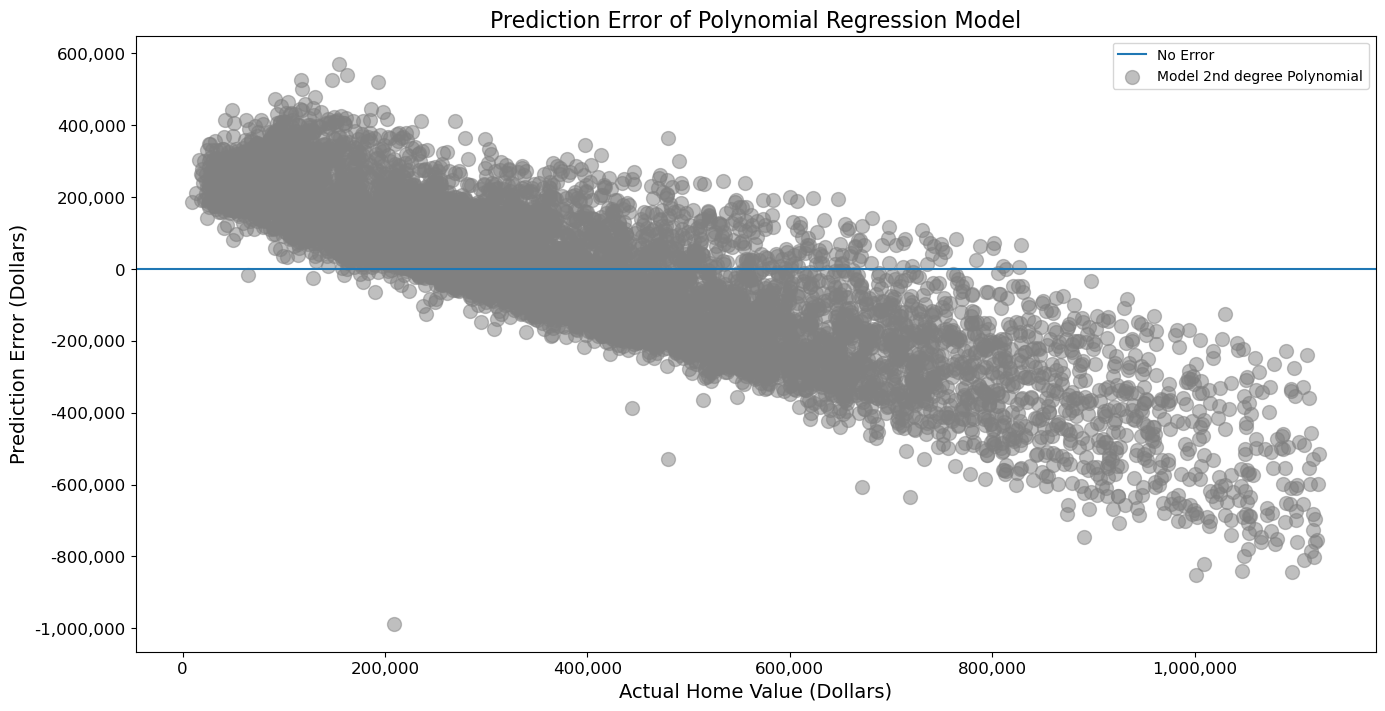

In [83]:
get_pred_error_plot(y_test)